# Working with objects

This notebook will show how to exchange objects (e.g. annotations, detections) between QuPath and Python.

As we will communicate with QuPath, it is recommended to go through the *communicating_with_qupath.ipynb* notebook first.

Before running this notebook, you should launch QuPath, start the Py4J gateway, and open an image that has a few annotations.

In [1]:
from qubalab.qupath import qupath_gateway

token = None   # change the value of this variable if you provided a token while creating the QuPath gateway
port = 25333   # change the value of this variable if you provided a different port while creating the QuPath gateway
gateway = qupath_gateway.create_gateway(auth_token=token, port=port)

print("Gateway created")

Gateway created


## Get objects from QuPath

We will first see how to get objects from QuPath. As mentionned in the *communicating_with_qupath.ipynb* notebook, there are two ways to communicate with QuPath:
- Use one of the functions of `qubalab.qupath.qupath_gateway`.
- If no function exists for your use case, use `gateway.entry_point`.

In our case, the `qubalab.qupath.qupath_gateway` file has a `get_objects()` function that suits our goal, so we will use it.

This function has an `object_type` parameter to define which type of object to retrieve. We will work with annotations here:

In [2]:
from qubalab.objects.object_type import ObjectType

object_type = ObjectType.ANNOTATION    # could be detection, cell, ...

### Get annotations as `JavaObject`

In [3]:
annotations = qupath_gateway.get_objects(object_type = object_type)

for annotation in annotations:
    print(annotation)

Hello from Python
Hello from Python (Other)


By default, the returned objects are Java objects.

This is useful if we want to do something that isn't supported by the `qubalab.qupath.py4j` module, but it isn't very convenient... we end up needing to write Python code that looks a *lot* like Java code. We can also get stuck when things get complicated (e.g. due to threading issues) because we don't have the ability to do *everything* Java can do.

We *can* make changes though, like setting names and classifications, which is nice.

If we do, we should remember to call `qupath_gateway.refresh_qupath()` to update the interface accordingly.

In [4]:
annotation = annotations[0]

# Change the QuPath annotation
annotation.setName("Hello from Python")

# Refresh the QuPath interface. You should see the changes in QuPath
qupath_gateway.refresh_qupath()

### Get annotations as `GeoJSON`

There's another approach we can take. Rather than directly accessing the QuPath objects, we can request them as GeoJSON. This does *not* give direct access, but rather imports a more Python-friendly representation that is no longer connected to QuPath.

In [5]:
annotations = qupath_gateway.get_objects(object_type = object_type, converter='geojson')

for annotation in annotations:
    print(annotation)

{"geometry": {"coordinates": [[[22161, 7576], [27541, 7576], [27541, 13932], [22161, 13932], [22161, 7576]]], "plane": {"t": 0, "z": 0}, "type": "Polygon"}, "id": "71d6c4b9-56e8-4922-8552-7a966d869dbf", "properties": {"color": [165, 165, 229], "name": "Hello from Python", "objectType": "annotation"}, "type": "Feature"}
{"geometry": {"coordinates": [[[18013, 15255], [18006.97, 15424.47], [17988.9, 15593.27], [17958.87, 15760.74], [17916.99, 15926.21], [17863.43, 16089.04], [17798.4, 16248.57], [17722.15, 16404.18], [17634.99, 16555.25], [17537.27, 16701.2], [17429.36, 16841.43], [17311.69, 16975.41], [17184.73, 17102.59], [17048.98, 17222.49], [16904.97, 17334.62], [16753.27, 17438.54], [16594.49, 17533.84], [16429.24, 17620.15], [16258.18, 17697.13], [16081.99, 17764.47], [15901.36, 17821.9], [15717, 17869.21], [15529.64, 17906.19], [15340.02, 17932.72], [15148.89, 17948.67], [14957, 17954], [14765.11, 17948.67], [14573.98, 17932.72], [14384.36, 17906.19], [14197, 17869.21], [14012.64,

In practice, it's really a slightly 'enhanced' GeoJSON representation, because it includes a few extra fields that are relevant for QuPath.

This includes any classification, name, color and object type. It also includes a plane, which stores `z` and `t` indices.

But because it is still basically GeoJSON, we can use it with other Python libraries that supports GeoJSON... such as `geojson`.

In [6]:
import geojson

print(geojson.dumps(annotations[0], indent=2))

{
  "type": "Feature",
  "id": "71d6c4b9-56e8-4922-8552-7a966d869dbf",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          22161,
          7576
        ],
        [
          27541,
          7576
        ],
        [
          27541,
          13932
        ],
        [
          22161,
          13932
        ],
        [
          22161,
          7576
        ]
      ]
    ],
    "plane": {
      "z": 0,
      "t": 0
    }
  },
  "properties": {
    "name": "Hello from Python",
    "color": [
      165,
      165,
      229
    ],
    "objectType": "annotation"
  }
}


We can also use it with `Shapely`, which is particularly useful.

Shapely gives us access to lots of useful methods - and shapely objects can be displayed nicely in a Jupyter notebook.

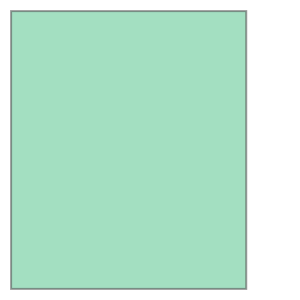

In [7]:
from shapely.geometry import shape

shape(annotations[0].geometry)

## Add and remove objects from QuPath

The GeoJSON representation doesn't give us direct access to the QuPath objects, but we can still make changes and send them back.

The easiest way to see this in action is to begin by deleting the annotations and then adding them back again - but this time with a different color.

> We only assign colors to annotations that aren't classified, so that we don't override the colors that QuPath uses for classification.

In [8]:
import random

for annotation in annotations:
    if not annotation.classification:
        annotation.color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

qupath_gateway.delete_objects(object_type = object_type)
qupath_gateway.add_objects(annotations)

## Create masks & labeled images

One reason to use Python rather than QuPath/Java is that NumPy/SciPy/scikit-image and other tools make working with pixels easier and more fun.

To begin, let's use the GeoJSON representation to create masks and labeled images.

To create masks and labeled images, Qubalab has a `LabeledImageServer` class. This class is an implementation of the qubalab `ImageServer` which is described in the *opening_images.ipynb* notebook, so it is recommended that you go through this notebook first.

This server needs:
- Some metadata representing the image containing the objects. Since we are working with the image that is opened in QuPath, we can the metadata of the `QuPathServer`, as described in *communicating_with_qupath.ipynb*.
- The objects to represent. We will give the annotations we've been working with.
- A downsample to apply to the image.

Once the server is created, all functions described in *opening_images.ipynb* (such as `read_region()` to read the image) are also available.

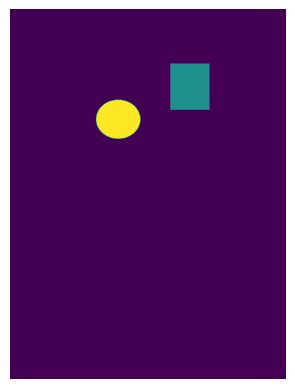

In [9]:
from qubalab.images.qupath_server import QuPathServer
from qubalab.images.labeled_server import LabeledImageServer

metadata = QuPathServer(gateway).metadata
downsample = 20

labeled_server = LabeledImageServer(metadata, annotations, downsample=downsample)
label_image = labeled_server.read_region()

# This calls a utility function from qubalab to plot the image
from qubalab.display.plot import plotImage
plotImage(label_image)

By default, the `LabeledImageServer` will return a single channel image where all objects are represented by integer values (labels). It's a labeled image.

Another option is to create a multi channel image where each channel is a mask indicating if an annotation is present:

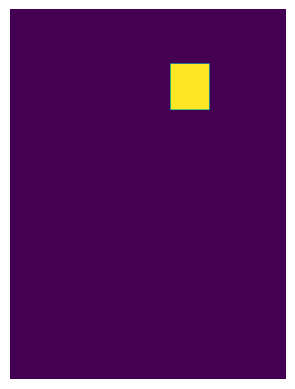

In [12]:
mask_server = LabeledImageServer(metadata, annotations, downsample=downsample, multichannel=True)

masks = mask_server.read_region()

# masks contains (n+1) channels, where n is the number of annotations
# The i channel corresponds to the mask representing the i annotation
# Let's plot the first mask
plotImage(masks, channel=1)

## Image processing & creating objects

This whole thing becomes more useful when we start to use Python for image processing.

Here we'll use scikit-image to help find objects using two different thresholding methods. We'll then convert them to QuPath objects and add them to the current QuPath viewer for visualization.